Affine coordinate space has parrallel lines eg. cartesian coordinate space

In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15
from scipy.ndimage import measurements
import matplotlib.cm as cm

Image moments by $$M_{ij} = \Sigma_x \Sigma_y x^{i} y^{j} f(x,y)$$
Centroid $$\bar{x} = M_{10}/M_{00}, \bar{y} = M_{01}/M_{00}$$

Central moments = $$ \Sigma_x \Sigma_y (x-\bar{x})^{i} (y-\bar{y})^{j} f(x,y) $$

In [97]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in degrees between vectors 'v1' and 'v2' """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

((-4, 4), (-4, -4))


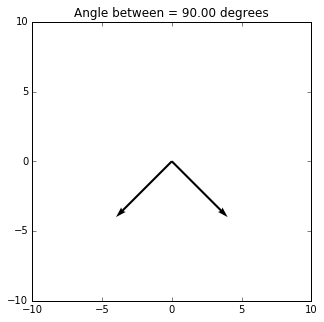

In [53]:
soa =np.array( [ [0,0,-4,-4], [0,0,4,-4]]) 
X,Y,U,V = zip(*soa)
print(U,V)
fig = plt.figure()
fig.set_size_inches(5, 5)

ax = plt.gca()
ax.quiver(X,Y,U,V,angles='xy',scale_units='xy',scale=1)
ax.set_xlim([-10,10])
ax.set_ylim([-10,10])
angle = angle_between(U,V)
plt.title("Angle between = {0:.2f} degrees".format(angle))
plt.draw()
plt.show()

In [206]:
def getRedYellow(r):
    notRedOrYellow = (r[:,:,0] < 150) & (r[:,:,1] < 150) | (r[:,:,2] > 100)
    r[notRedOrYellow] = 0
    return r

def getImgMoments(im,channel):
    img = im.copy()
    h,w,c = img.shape
    #'print("h/w/c = {0}".format(tuple((h,w,c))))
    c = img[:,:,channel]
    x,y = np.arange(w), np.arange(h)
    X,Y = np.meshgrid(x,y)

    m00 = (c).sum()
    m10 = (c*X).sum()
    m01 = (c*Y).sum()
    xBar = (m10/m00).astype(np.uint32)
    yBar = (m01/m00).astype(np.uint32)
    centroid = np.array([xBar,yBar])

    m20 = (c*(X**2)).sum()
    m02 = (c*(Y**2)).sum()
    m11 = (c*Y*X).sum()

    mu20 = m20/m00 - xBar**2
    mu02 = m02/m00 - yBar**2
    mu11 = m11/m00 - xBar*yBar
    cov = np.array([[mu20,mu11],[mu11,mu02]])

    #print("Eigenvectors",e1,e2)
    return centroid, cov

In [209]:
def getEigenVectors(centroid1,centroid2,cov):
    
    eigenVals, eigenVectors = np.linalg.eig(cov)
    idx = abs(eigenVals).argsort()[::-1] #Order eigen-system
    eigenVals = eigenVals[idx]
    eigenVectors = eigenVectors[:,idx]

    e1 = eigenVectors[:,0]
    e2 = eigenVectors[:,1]
    
    redGreenDirection = centroid1.astype(np.float32)-centroid2.astype(np.float32)
    angleBetween = angle_between(redGreenDirection,e1)
    if angleBetween < 90: #If (centroid of green - centroid of red) (dotProd) first eigenvector then flip direction 
        e1*=-1
    if np.linalg.det(eigenVectors)<0: #Make sure determinant==1 so not mirror imaging
        e2*=-1
        
    evs = np.array([e1,e2])
    return evs

def rotate(orig,mask,evs,centroid,scale= 1.0):
    h,w,c = mask.shape
    angle = np.degrees(np.arctan2(evs[1][0],evs[0][0]))
    centroid = totuple(centroid)
    M = cv2.getRotationMatrix2D(centroid,-angle,1)
    print("To be rotated by {0:.2f} about {1}".format(angle,centroid))
    origDst = cv2.warpAffine(orig, M,(w,h),borderValue=0)
    maskDst = cv2.warpAffine(mask, M,(w,h),borderValue=0)
    return origDst,maskDst
    

To be rotated by -132.79 about (1655, 690)


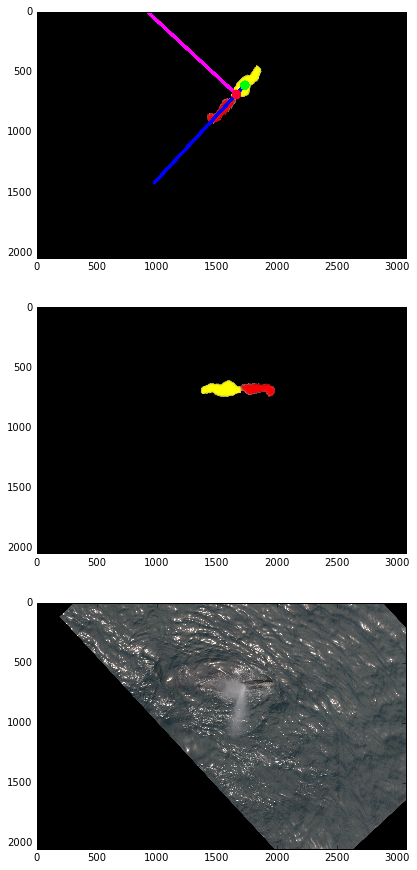

To be rotated by 137.88 about (1936, 1408)


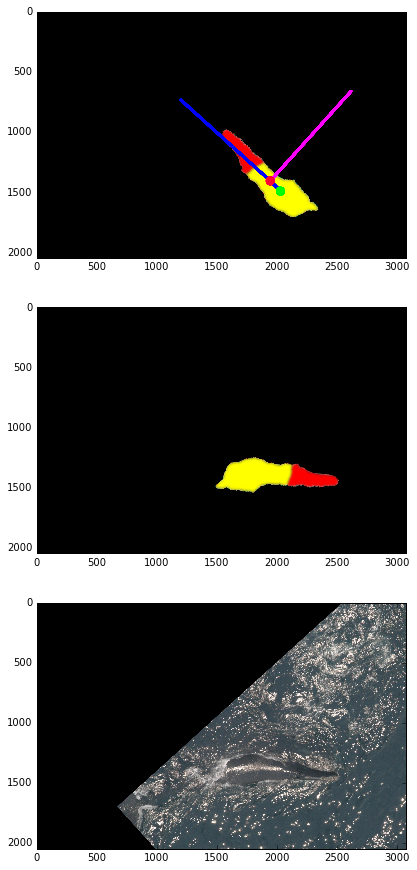

To be rotated by 146.18 about (3336, 2083)


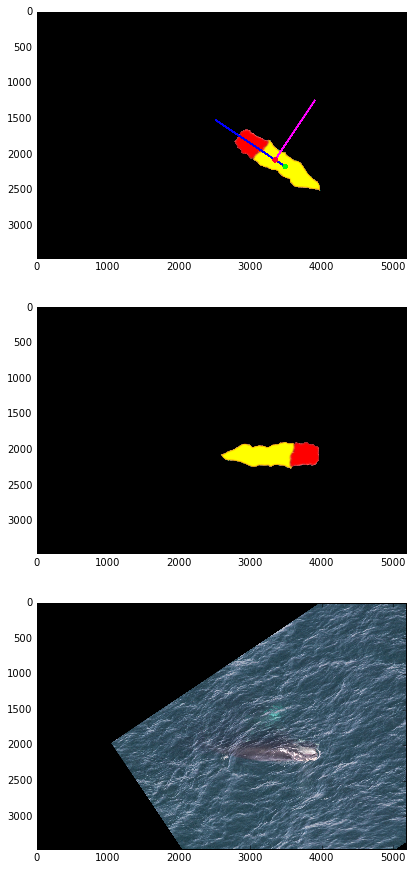

To be rotated by -96.41 about (1532, 1262)


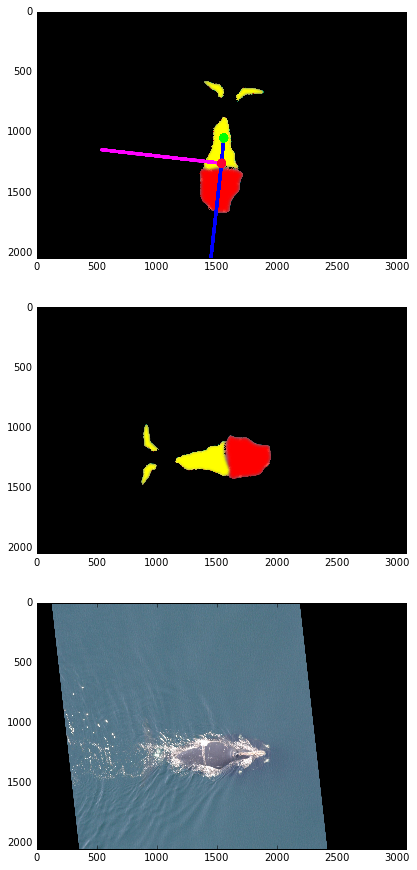

To be rotated by -40.61 about (1559, 1102)


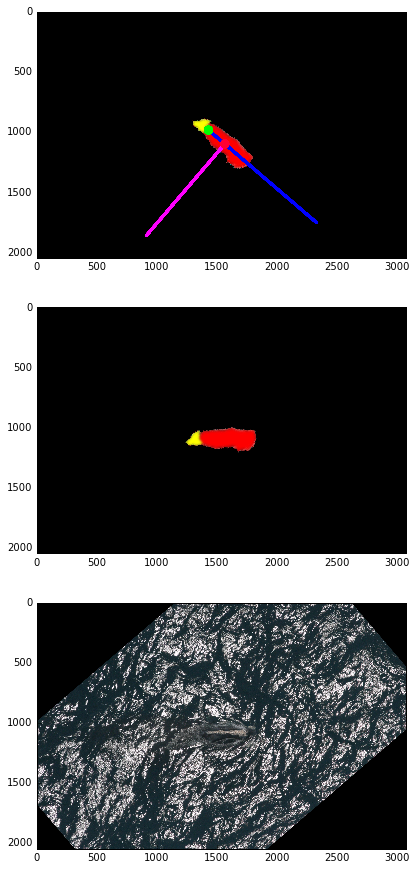

To be rotated by -151.83 about (1460, 744)


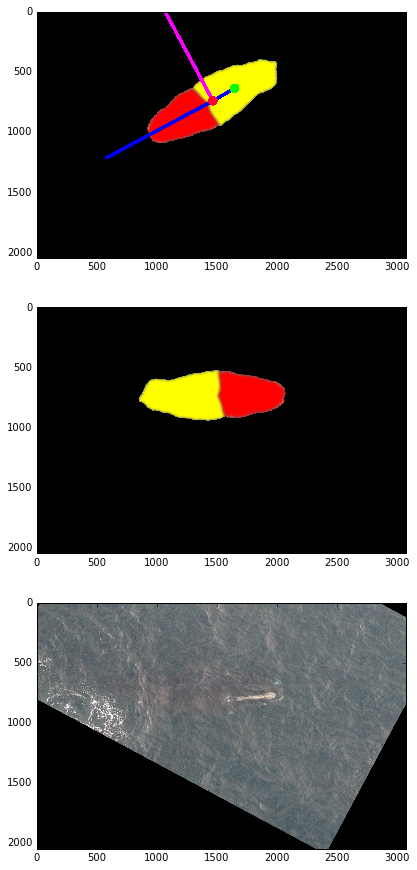

To be rotated by 178.21 about (3129, 1850)


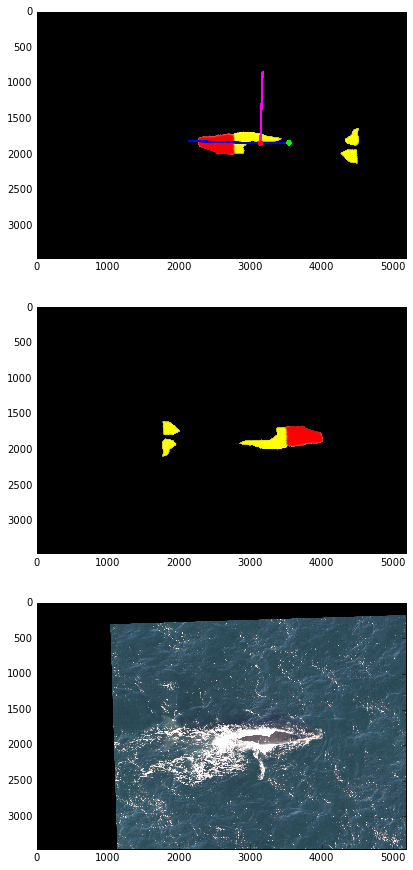

To be rotated by 140.79 about (1600, 1219)


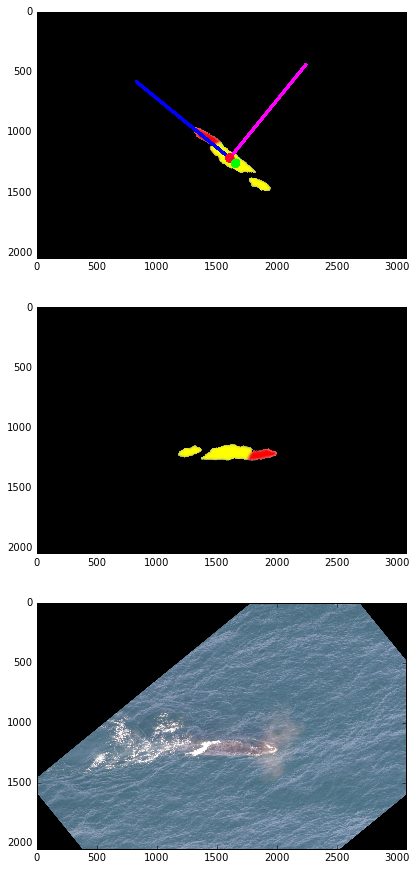

To be rotated by 179.71 about (1595, 1098)


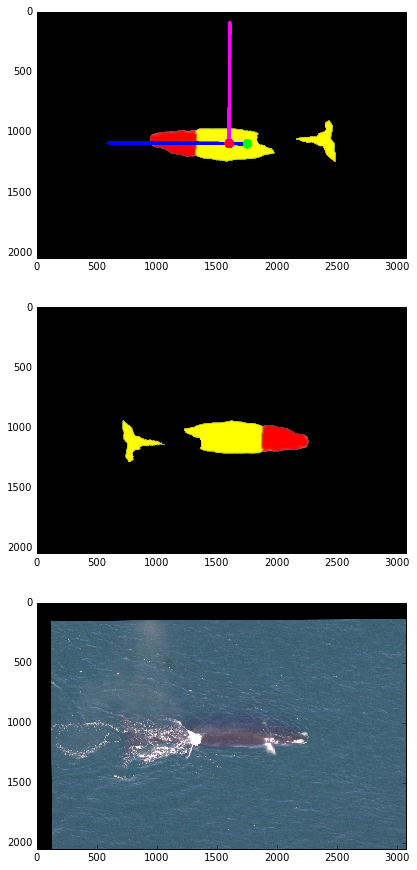

To be rotated by 83.36 about (2786, 2003)


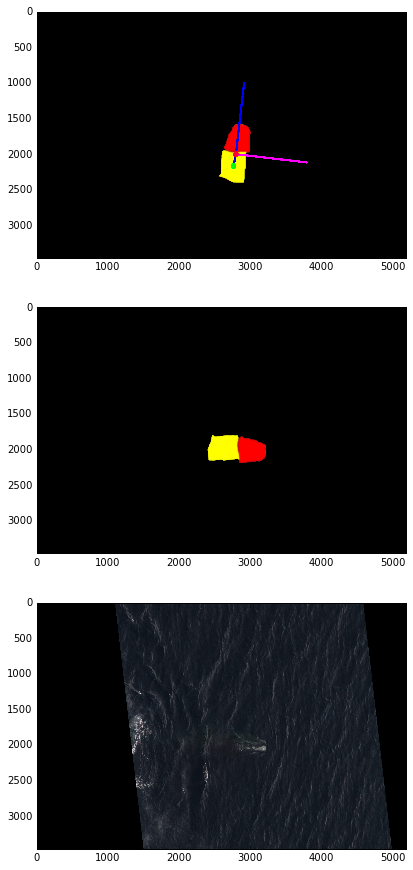

To be rotated by 33.53 about (1258, 985)


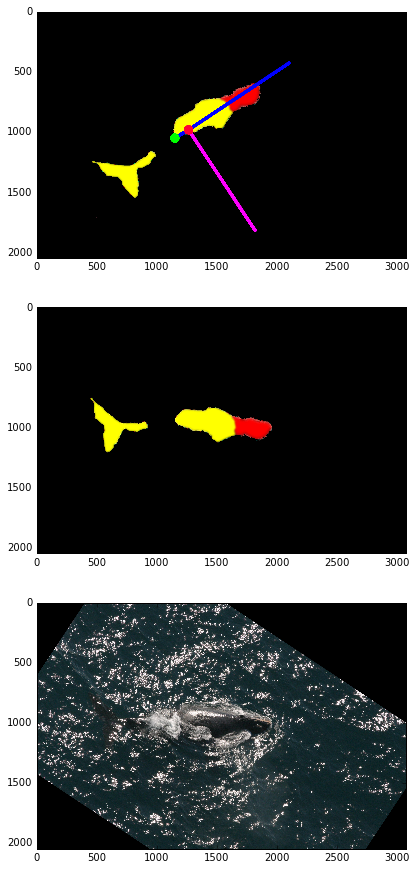

To be rotated by 141.19 about (1580, 1252)


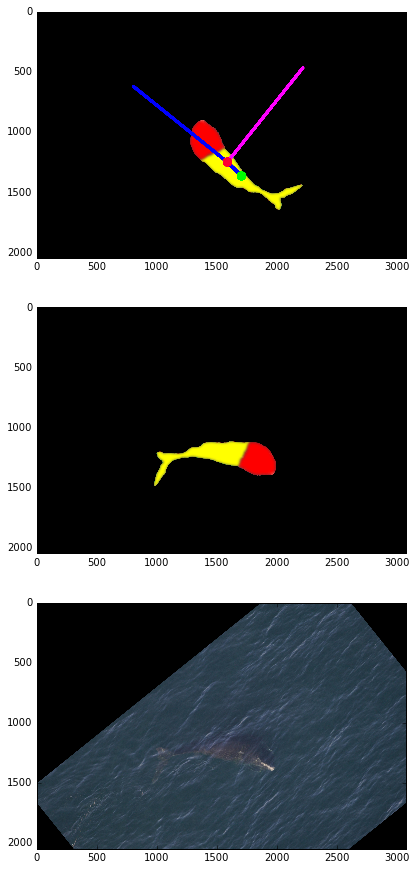

To be rotated by -128.33 about (1673, 844)


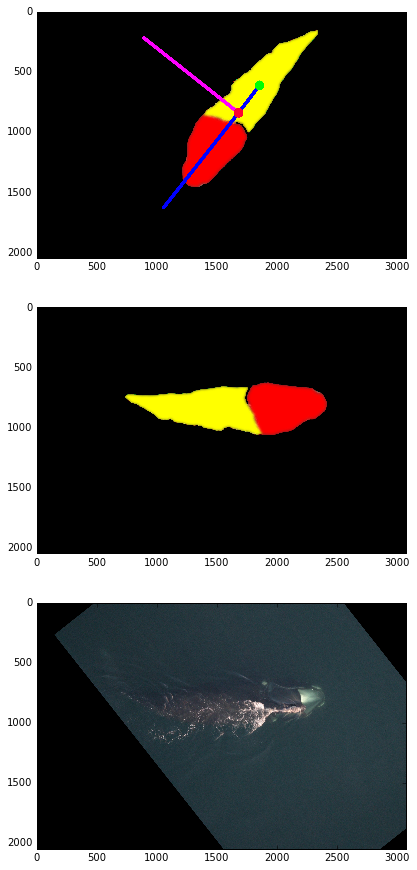

To be rotated by -68.55 about (2317, 1825)


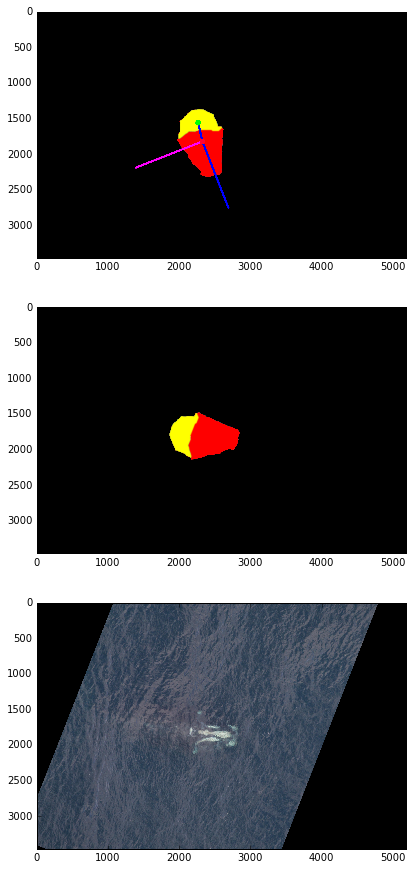

To be rotated by -161.24 about (1780, 1448)


In [ ]:
imgPaths = glob.glob("/home/msmith/kaggle/whale/imgs/*/l_*")
for i in np.random.permutation(len(imgPaths))[:15]:

    imPath = imgPaths[i]

    orig = cv2.imread(imPath.replace("l_","w1_"))[:,:,::-1]
    mask = cv2.imread(imPath)[:,:,::-1]
    h,w,c = mask.shape
    channel = 0 #Red
    
    # Call fns
    mask = getRedYellow(mask)
    centroidR, covR = getImgMoments(mask,0)
    centroidG, covG = getImgMoments(mask,1)
    e1,e2 = evs = getEigenVectors(centroid1=centroidG,centroid2=centroidR,cov=covR)
    
    rotOrig = orig.copy()
    rotMask = mask.copy()
    
    rotOrig, rotMask = rotate(rotOrig,rotMask,evs,centroidR)
    
    # For display 
    arroLen = 1000
    arrowToE1 = tuple((centroidR + (e1)*arroLen).astype(np.uint16))
    arrowToE2 = tuple((centroidR + (e2)*arroLen).astype(np.uint16))
    centroidRT = totuple(centroidR)
    centroidGT = totuple(centroidG)
    
    dis = mask.copy()
    cv2.line(dis,centroidRT,arrowToE1,(0,0,255),30)
    cv2.line(dis,centroidRT,arrowToE2,(255,0,255),30)
    cv2.line(dis,centroidGT,centroidRT,(0,0,255),30)
    cv2.circle(dis,centroidRT,40,(255,0,50),-1,lineType=8)
    cv2.circle(dis,centroidGT,40,(0,255,0),-1)
    plt.title(imPath)
    plt.subplot(311)
    plt.imshow(dis,cmap=cm.gray); 
    plt.subplot(312)
    plt.imshow(rotMask,cmap=cm.gray);
    plt.subplot(313)
    plt.imshow(rotOrig);
    plt.show()